<h1 style="text-align: center; color: blue;">
ADS ~ UNIFACISA <br>
Projeto Integrador IA
</h1>

#### Autor : Tawan Barbosa da Silva
#### Desafio Unifacisa ~ Questão 10


---

> # <center>Previsão de Vendas Mensais em Rede de Varejo 📊 </center>

---

# 1. Ask ~ Pergunta Principal

---

## Pergunta Principal

><i> **Com base em variáveis operacionais e promocionais (publicidade, funcionários, sazonalidade), qual é o modelo de Machine Learning mais preciso para prever as vendas mensais, garantindo a menor margem de erro?"**
</i>


## Objetivo do Projeto


><i> O objetivo técnico é construir, treinar e comparar múltiplos modelos de regressão para previsão de vendas, focando em:
</i>

* Minimizar o Erro: Atingir o menor valor de RMSE e MAE no conjunto de testes.
* Maximizar o Ajuste: Obter o maior valor de $R^2$ (Coeficiente de Determinação).
* Identificar Fatores Chave: Realizar a Análise de Importância de Variáveis para determinar quais fatores (publicidade, promoções, etc.) são mais impactantes nas vendas.


---

# 2. Prepare ~ Coleta e Entendimento dos Dados
---
><i> **Usaremos o dataset Rossmann Store Sales (Kaggle)**


<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Principais Arquivos:</h3> <br>

store.csv — Informações fixas sobre cada loja (StoreType, Assortment, CompetitionDistance, Promo2, etc.)

train.csv — Vendas históricas diárias (Date, Store, Sales, Customers, Promo, SchoolHoliday, etc.)

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Caminho do Dataset e Load dos Dados
path = Path('/kaggle/input/rossmann-store-sales')

store = pd.read_csv(path / 'store.csv')
train = pd.read_csv(path / 'train.csv', low_memory=False)

# 1. Inspeção Inicial
print("--- Inspeção Inicial ---")
print(f"Shape do Treino (Vendas): {train.shape}")
print(f"Shape da Store (Características das Lojas): {store.shape}")

# Merge dos Dados
df = train.merge(store, on='Store', how='left')

# Limpeza de Dados (Remoção de Vendas Zeradas)
df = df[df['Sales'] > 0]

print(f"\nShape Final Após Junção e Remoção de Vendas Zeradas: {df.shape}")
display(df.head())

--- Inspeção Inicial ---
Shape do Treino (Vendas): (1017209, 9)
Shape da Store (Características das Lojas): (1115, 10)

Shape Final Após Junção e Remoção de Vendas Zeradas: (844338, 18)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


---
# 3. Process ~ Feature Engineering e Pré-processamento
Esta fase realiza um tratamento e transforma os dados brutos em um formato que os modelos podem entender.

---

<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Tarefas:</h3> <br>

* Engenharia de Variáveis de Tempo: Desdobramento da data (Date) em variáveis de sazonalidade (Year, Month, WeekOfYear) para capturar o impacto do tempo nas vendas.

* Tratamento de Ausentes e Conversão: Preenchimento de valores faltantes (NaN) e conversão das características de loja (StoreType, Assortment) de texto para formato numérico (codificação).

* Limpeza Final de Dados: Remoção de colunas textuais redundantes (Date, PromoInterval) e seleção das variáveis preditivas para a regressão.

In [2]:
# Feature Engineering

# Tratamento de Datas
# A coluna 'Date' é convertida e decomposta para capturar a sazonalidade

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int) # Sazonalidade semanal/mensal


# Tratamento de variaveis ausentes (NaN)
# A tabela 'store' possui alguns valores ausentes que precisam ser preenchidos:
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0)
df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0)
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0)

# Tratamento de variaveis categoricas e nominais

store_type_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
df['StoreType'] = df['StoreType'].map(store_type_mapping)

assortment_mapping = {'a': 1, 'b': 2, 'c': 3}
df['Assortment'] = df['Assortment'].map(assortment_mapping)

state_holiday_mapping = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
df['StateHoliday'] = df['StateHoliday'].replace(state_holiday_mapping).astype(int)

# Dropar colunas que não são mais necessárias ou são textuais
df = df.drop(columns=['Date', 'Customers', 'Store', 'PromoInterval']) 

print(f"Colunas finais para modelagem: {df.columns.tolist()}")

# O valor alvo (target) será a coluna 'Sales'
TARGET_COLUMN = 'Sales'

Colunas finais para modelagem: ['DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear']


/tmp/ipykernel_13/708203886.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['StateHoliday'] = df['StateHoliday'].replace(state_holiday_mapping).astype(int)


---
# 4. Analyze ~ Modelagem e Primeira Comparação

>  Nesta fase, construiremos os modelos, treinaremos e compararemos o desempenho.

In [3]:
#Código de Modelagem e Comparação


# Features, Target e Divisão de Treino/Teste
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Normalização (regressão linear)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Apenas transforma os dados de teste (usa os parâmetros de treino)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame (para manter os nomes das colunas)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Definir Modelos
models = {
    "Regressão Linear": LinearRegression(),
    "Árvore de Decisão": DecisionTreeRegressor(random_state=42, 
                                               max_depth=10),
    "XGBoost": XGBRegressor(random_state=42, 
                            n_estimators=100, 
                            learning_rate=0.1, n_jobs=-1)
}

results = []
best_model_name = ""
best_rmse = float('inf')

# Treinamento, Previsão e Avaliação
for name, model in models.items():
    start_time = time.time()
    
    if name == "Regressão Linear":
        # Usa dados normalizados (scaled)
        X_train_data = X_train_scaled_df
        X_test_data = X_test_scaled_df
    else:
        # Usa dados originais (não normalizados)
        X_train_data = X_train
        X_test_data = X_test

    # Treinamento
    model.fit(X_train_data, y_train)
  
    # Previsão
    y_pred = model.predict(X_test_data)
    
    # Calculo de métricas
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    end_time = time.time()
    
    results.append({
        'Modelo': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Tempo (s)': round(end_time - start_time, 2)
    })
    
    # Verifica melhor modelo
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_model = model

# Converte resultados para DataFrame para visualização
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n--- Tabela de Comparação de Desempenho ---")
display(results_df)


--- Tabela de Comparação de Desempenho ---


,Modelo,RMSE,MAE,R2,Tempo (s)
2,XGBoost,1836.984277,1341.958881,0.650294,4.50
1,Árvore de Decisão,2208.959635,1596.008723,0.494329,3.16
0,Regressão Linear,2795.242148,2031.977623,0.190287,0.81


---

# 5. Share ~ Visualizar e Comparar Resultados

Nesta fase iremos visualizar e entender as avaliações dos 3 modelos e também medir a importância de cada variável

---

## 5.1 Avaliação dos Modelos

<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Resumo das Métricas de Avaliação:</h3> <br>

As métricas utilizadas para avaliar o desempenho dos modelos de regressão são o RMSE, o MAE e o R².
Enquanto RMSE e MAE medem o **erro das previsões (quanto menor, melhor)**, o R² mede o quanto o modelo explica a **variabilidade dos dados (quanto maior, melhor)**.

> MAE (Erro Médio Absoluto): Representa a média do erro absoluto entre as previsões e os valores reais. Um MAE de X indica que o modelo erra, em média, X unidades da variável-alvo. É a métrica mais intuitiva para entender o erro médio.

> RMSE (Raiz do Erro Quadrático Médio): Similar ao MAE, mas penaliza mais fortemente erros grandes. É considerada uma métrica mais rigorosa, pois grandes desvios impactam significativamente o resultado.

> R² (Coeficiente de Determinação): Mede o quanto da variação dos valores reais é explicada pelo modelo. Seu valor varia entre 0 e 1 — quanto mais próximo de 1, melhor o ajuste. Um R² baixo indica que o modelo ainda não consegue capturar bem as relações entre as variáveis.



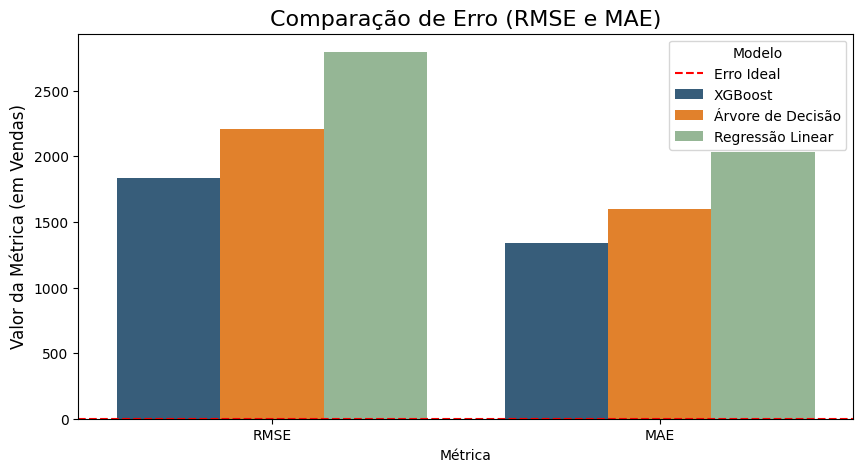

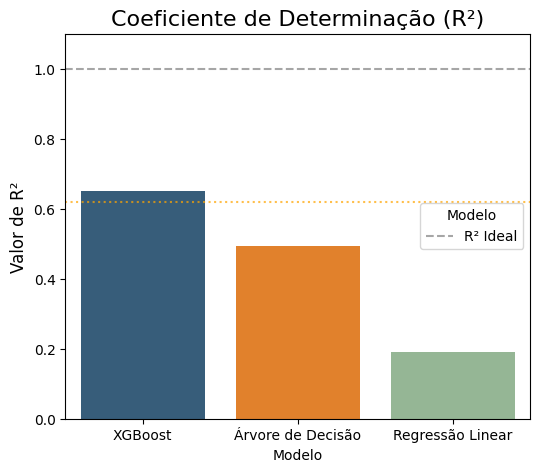

In [4]:
cores = ['#2C5F85', '#FF7F0E', '#8FBC8F']

results_melted_erro = results_df.melt(id_vars='Modelo', 
                                     value_vars=['RMSE', 'MAE'],
                                     var_name='Métrica', 
                                     value_name='Valor')

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Métrica', 
    y='Valor', 
    hue='Modelo', 
    data=results_melted_erro, 
    palette=cores 
)
plt.title('Comparação de Erro (RMSE e MAE)', fontsize=16)
plt.ylabel('Valor da Métrica (em Vendas)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', label='Erro Ideal')
plt.legend(title='Modelo')
plt.show()

# Filtra apenas o R2
results_r2 = results_df.melt(id_vars='Modelo', 
                            value_vars=['R2'],
                            var_name='Métrica', 
                            value_name='Valor')

plt.figure(figsize=(6, 5))
sns.barplot(
    x='Modelo', 
    y='Valor', 
    data=results_r2, 
    palette=cores 
)
plt.title('Coeficiente de Determinação (R²)', fontsize=16)
plt.ylabel('Valor de R²', fontsize=12)
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7, label='R² Ideal')
plt.axhline(y=results_r2['Valor'].max() * 0.95, color='orange', linestyle=':', alpha=0.7) # Linha de referência
plt.ylim(0.0, 1.1) # Limita o eixo Y para visualizar melhor o 0 a 1
plt.legend(title='Modelo')
plt.show()

---

## 5.2 Importância das Variáveis

<h3 style="color: #FF4500; margin-top: 0; margin-bottom: 5px;">Resumo das Variáveis Impactantes:</h3> <br>

Na Regressão Linear, a importância é direta e causal: o valor e o sinal do coeficiente ($\beta$) de cada variável indicam a magnitude e a direção exata de sua influência na variável alvo (explicando como um aumento na variável X afeta Y). Já em modelos de Machine Learning mais complexos, como Árvore de Decisão e XGBoost, a importância é preditiva: ela é medida pelo Ganho ou Frequência com que a variável foi utilizada para reduzir o erro do modelo, priorizando a precisão em vez da explicabilidade. Assim, enquanto a Regressão Linear oferece uma fórmula transparente de causa e efeito, os modelos baseados em árvores fornecem um ranking do poder preditivo de cada variável.


Top 10 Coeficientes (Importância) da Regressão Linear:


,Feature,Coefficient,Abs_Coefficient,Sinal
12,Promo2SinceYear,-39159.354953,39159.354953,Negativo
10,Promo2,38517.119800,38517.119800,Positivo
2,Promo,1067.563735,1067.563735,Positivo
6,Assortment,410.334774,410.334774,Positivo
11,Promo2SinceWeek,302.181767,302.181767,Positivo
14,Month,249.869814,249.869814,Positivo
0,DayOfWeek,-234.316956,234.316956,Negativo
7,CompetitionDistance,-225.221349,225.221349,Negativo
8,CompetitionOpenSinceMonth,-193.987380,193.987380,Negativo
9,CompetitionOpenSinceYear,186.816258,186.816258,Positivo


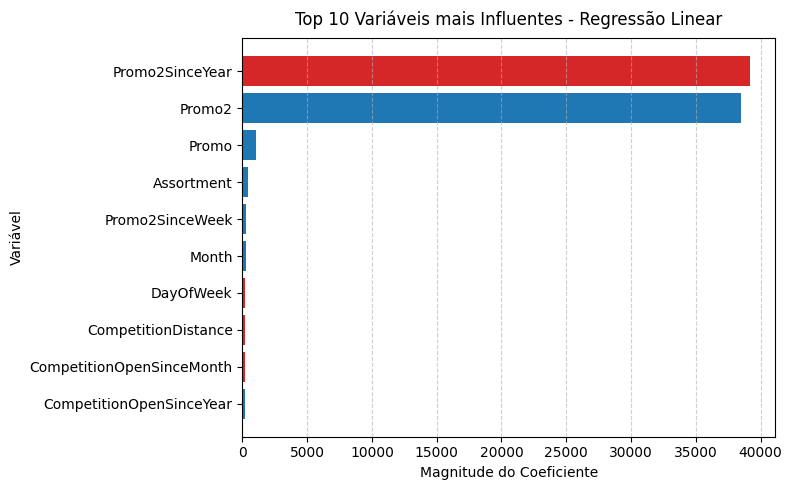

In [5]:
# Importância Regressão Linear


linear_model = models["Regressão Linear"]

# Coeficientes
coefficients = linear_model.coef_
features = X_train.columns

# DataFrame com coeficientes e magnitude absoluta
importance_df_lr = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients),
    "Sinal": np.where(coefficients >= 0, "Positivo", "Negativo")
}).sort_values(by="Abs_Coefficient", ascending=False)

print("\nTop 10 Coeficientes (Importância) da Regressão Linear:")
display(importance_df_lr.head(10))

top10 = importance_df_lr.head(10).iloc[::-1]

# Vermelho para Negativo e Azul para Positivo
colors = ["#1f77b4" if s == "Positivo" else "#d62728" for s in top10["Sinal"]]

plt.figure(figsize=(8,5))
plt.barh(top10["Feature"], top10["Abs_Coefficient"], color=colors)
plt.title("Top 10 Variáveis mais Influentes - Regressão Linear", fontsize=12, pad=10)
plt.xlabel("Magnitude do Coeficiente", fontsize=10)
plt.ylabel("Variável", fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


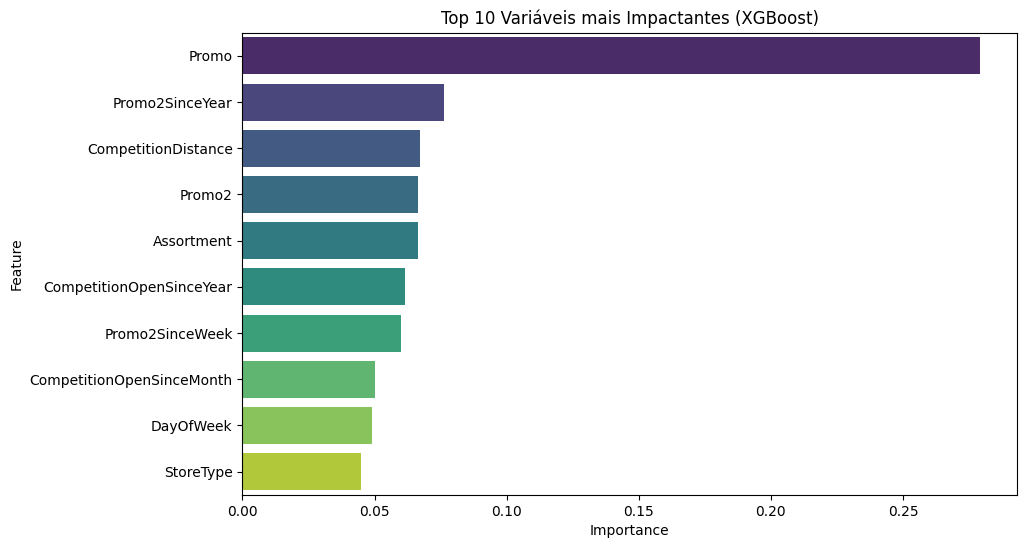

In [6]:
# Importância Árvore de Decisão e XGBoost.
if best_model_name != "Regressão Linear":
    
    importances = best_model.feature_importances_
    features = X_train.columns
    
    # Cria DataFrame para ordenação
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)

    # Visualização
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
    plt.title(f'Top 10 Variáveis mais Impactantes ({best_model_name})')
    plt.show()

---

# 6. Act ~ Conclusão e Insights para o Varejo

Esta fase consolida os resultados da modelagem para responder às perguntas centrais do negócio.

## 6.1 Qual Modelo Apresentou a Menor Margem de Erro?

Conforme a **Tabela de Comparação de Desempenho**, o modelo que demonstrou a maior eficiência e a menor margem de erro foi o **XGBoost**.

### Tabela de Comparação de Desempenho (Previsão de Vendas)

| Métrica | Modelo | Valor | Status | Observação |
| :--- | :--- | :--- | :--- | :--- |
| **RMSE** (Erro Quadrático) | **XGBoost** | **1836.98** | **Melhor** | Menor erro, penaliza menos os erros grandes. |
| | Árvore de Decisão | 2208.96 | Bom | Diferença significativa para o XGBoost. |
| | Regressão Linear | 2795.24 | Pior | Maior erro em todas as métricas. |
| **MAE** (Erro Absoluto) | **XGBoost** | **1341.96** | **Melhor** | O erro médio real das previsões é o menor. |
| | Árvore de Decisão | 1596.01 | Bom | Erro médio aceitável. |
| | Regressão Linear | 2031.98 | Pior | Erro médio mais alto. |
| **$R^2$** (Variância Explicada) | **XGBoost** | **0.650** | **Melhor** | O modelo explica 65% da variação nas Vendas. |
| | Árvore de Decisão | 0.494 | Bom | Explica quase 50% da variação. |
| | Regressão Linear | 0.190 | Pior | Explica apenas 19% da variação (Confirma fraco desempenho). |


* **Modelo Vencedor:** XGBoost
* **Performance:** Obteve o menor **RMSE** (Erro Quadrático Médio) e o maior **R²** (Coeficiente de Determinação).
    * *O XGBoost é ideal para dados de varejo por sua capacidade de capturar relações complexas e não-lineares, superando a simplicidade da Regressão Linear.*

## 6.2 Quais Variáveis Tiveram Maior Impacto nas Previsões?

* Promoção 1 **(Promo)**: Lidera no XGBoost e tem impacto considerável na Regressão Linear.

* **Promoção Contínua 2 (Promo2)** e seu Fator Tempo **(Promo2SinceYear)**: Dominam o ranking da Regressão Linear e são muito relevantes no XGBoost.

O XGBoost (que teve o melhor desempenho geral) sugere que a Promoção Semanal (Promo) é o fator preditivo mais importante. Já a Regressão Linear atribui o maior peso à Promoção Contínua (Promo2) e ao tempo em que ela está ativa (Promo2SinceYear).
